### Historical

In [1]:
import requests
import pandas as pd
from sqlalchemy import create_engine, MetaData, delete
import numpy as np
from scipy.stats import linregress as fit

import time
import pickle
import os
from tqdm import tqdm

from datetime import timedelta, datetime
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

import utils

In [2]:
thresh = 100
interval = 15

location = 'Monza'
year = 2023
needed_session = 'Race'

track_config = pd.read_csv('config/track_config.csv')
driver_config = pd.read_csv(f'config/driver_config_{year}.csv')

track = track_config.query(f''' circuit_location == '{location}' ''')

circuit_length = int(track.circuit_length.iloc[0])
corners = eval(track.corners.iloc[0])
start_line = eval(track.start_line.iloc[0])
before_start_line = eval(track.before_start_line.iloc[0])
after_start_line = eval(track.after_start_line.iloc[0])

In [3]:
#Session and circuit information

session = utils.get_session(location, year)
session_names = session.session_name[:2].tolist() #gave up on getting exactly fp1 & fp2 for knn, just getting the first two sessions of the weekend now
print(session_names)

session_key_fp1 = session.query(f'''session_name == '{session_names[0]}' ''').session_key.iloc[0]
session_key_fp2 = session.query(f'''session_name == '{session_names[1]}' ''').session_key.iloc[0]

session_key_race = session.query(f" session_name == '{needed_session}'").session_key.iloc[0]
race_start_time = pd.to_datetime(session.query(f" session_name == '{needed_session}'").date_start.iloc[0])
race_end_time = pd.to_datetime(session.query(f" session_name == '{needed_session}'").date_end.iloc[0])

driver_config = {row['name_acronym']:row['driver_number'] for ind, row in utils.get_data(f'https://api.openf1.org/v1/drivers?session_key={session_key_race}').iterrows()}
driver_config_reverse = {v: k for k, v in driver_config.items()}


['Practice 1', 'Practice 2']


In [8]:
pkl_filename = f"knn/knn_{location}-{year}_FP1_FP2_top25.pkl"
utils.save_knn_pickle(pkl_filename, session_key_fp1, session_key_fp2, start_line, before_start_line, after_start_line, LAP_THRESHOLDS = 25)

with open(pkl_filename, 'rb') as file:
    knn, start_line, before_start_line, after_start_line = pickle.load(file)

starting_grid = utils.get_starting_grid(session_key_race, race_start_time) 

knn/knn_Monza-2023_FP1_FP2_top25.pkl already exists
Done


In [9]:
# Connect to your SQL database
db_file = f"data/{session_key_race}.db"
if os.path.isfile(db_file):
    os.remove(db_file)
    print(f"Removing older DB file {db_file}")
print(f"Connecting to db using {db_file}")
engine = create_engine(f"sqlite:///{db_file}")

Removing older DB file data/9157.db
Connecting to db using data/9157.db


In [17]:
data = {}
data['data'] = {}
data['lap_number'] = {}
for driver_code, driver_number in driver_config.items():
  data['data'][driver_number] = pd.DataFrame()
  data['lap_number'][driver_code] = [1, 0]

In [18]:
# for timestamp in pd.date_range(race_start_time, race_end_time, freq = f'{interval}s'):
for timestamp in pd.date_range(race_start_time + timedelta(minutes = 1), race_end_time, freq = f'{interval}s'):

    # st = ses_start_time + timedelta(seconds=30)
    
    # while True:
    #   et = st + timedelta(seconds = interval)
    #   print(st,et)
    #   if et>ses_end_time:
    #     break

    t1 = time.time()
    st = timestamp
    et = st + timedelta(seconds = interval)
    
    weather_data = utils.get_weather_data(session_key_race, st, et)
    laptimes_data = utils.get_laptimes_data(session_key_race, st, et)
    position_data = utils.get_position_data(session_key_race, et)
    if len(weather_data):
        weather_data.map(str).to_sql('weather', engine, if_exists = 'append', index = False)
    if len(laptimes_data):
        laptimes_data.map(str).to_sql('laptimes', engine, if_exists = 'append', index = False)
    if len(position_data):
        position_data.map(str).to_sql('position', engine, if_exists = 'replace', index = False)
    
    car_data, location_data = utils.get_data_channels({'start_time' : st, 'end_time' : et, 'session_key' : session_key_race})
    telemetry_data = pd.DataFrame()
    
    for driver_code, driver_number in driver_config.items():
        try:
            merged_data = utils.merge_data_channels(car_data[car_data["driver_number"]==driver_number].sort_values(by="date"), location_data[location_data["driver_number"]==driver_number].sort_values(by="date"))
            merged_data['distance_l2'] = merged_data.apply(lambda row: utils.compute_l2((row.x, row.y), start_line, before_start_line, after_start_line), axis = 1)/10
            merged_data['distance_regr'] = knn.predict(np.asarray(merged_data[['x', 'y']]))
            merged_data['actual_distance'] = merged_data.apply(lambda row: utils.get_best_distance(row.distance_l2, row.distance_regr, thresh, circuit_length), axis = 1)
            merged_data.reset_index(inplace=True, drop=True)
            
            continuity_counter = 0
            for ind in merged_data.index[1:]:
                if merged_data.loc[ind, 'actual_distance'] - merged_data.loc[ind - (continuity_counter+1), 'actual_distance'] > 2000:
                  merged_data.drop([ind], inplace=True)
                  print(f'Deleted datapoints in {driver_code}s Lap{data["lap_number"][driver_code]}')
                  continuity_counter += 1
                else:
                  continuity_counter = 0
            
            merged_data.reset_index(inplace=True,drop=True)
            merged_data['lap_number'] = utils.assign_lap_number(merged_data, data['lap_number'][driver_code][0], circuit_length, data['lap_number'][driver_code][1])
            telemetry_data = pd.concat([telemetry_data, merged_data])
            data['lap_number'][driver_code][0] = merged_data.iloc[-1].lap_number
            data['lap_number'][driver_code][1] = merged_data.iloc[-1].actual_distance
        except Exception as e:
            print(f'{driver_number} failed')
            print(f'{e} exception')

    telemetry_data.to_sql('telemetry', engine, if_exists = 'append', index = False)
    print(et, time.time() - t1, sorted(data['lap_number'].items(), key = lambda kv: starting_grid[driver_config[kv[0]]]))
    time.sleep(10)
    # st = max(pd.to_datetime(car_data["date"].iloc[-1]), pd.to_datetime(location_data["date"].iloc[-1]))

2024-03-24 04:01:15 4.477993011474609 [('VER', [1, 3680.911527302467]), ('SAI', [1, 3581.4743219083557]), ('NOR', [1, 3476.8780928104707]), ('LEC', [1, 3304.698556851116]), ('PIA', [1, 3197.7398205179907]), ('PER', [1, 3080.8520066181604]), ('RUS', [1, 2945.819157904683]), ('TSU', [1, 2746.8780559038864]), ('STR', [1, 2588.052712480369]), ('ALO', [1, 2161.72358068687]), ('HAM', [1, 2010.7368771369272]), ('ALB', [1, 1829.9528287253504]), ('BOT', [1, 1753.517501837944]), ('MAG', [1, 1544.0611557774407]), ('OCO', [1, 1391.128303018902]), ('HUL', [1, 1287.1012821285237]), ('GAS', [1, 1242.3694739204946]), ('RIC', [1, 1201.6320760917451]), ('ZHO', [1, 5036.425979830506])]
2024-03-24 04:01:30 5.399791240692139 [('VER', [1, 4224.9104568776875]), ('SAI', [1, 4162.19370070153]), ('NOR', [1, 4120.971405897584]), ('LEC', [1, 4079.6286351990693]), ('PIA', [1, 4012.821936895524]), ('PER', [1, 3970.0946218243494]), ('RUS', [1, 3827.8472187937905]), ('TSU', [1, 3755.931551617061]), ('STR', [1, 3551.9

KeyError: 'date'

### Test laptime delta

In [64]:
import requests
import pandas as pd
from sqlalchemy import create_engine, MetaData, delete
import numpy as np
from scipy.stats import linregress as fit

import time
import pickle
import os
from tqdm import tqdm

from datetime import timedelta, datetime
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

import utils

import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

In [65]:
engine = create_engine(f"sqlite:///data/9488.db")
circuit_length = 5278

In [66]:
def delta_time(ref, comp):

    ref['actual_distance_smoothed'] = gaussian_filter1d(ref.actual_distance, sigma = 10)
    comp['actual_distance_smoothed'] = gaussian_filter1d(comp.actual_distance, sigma = 10)

    def mini_pro(stream):
        # Ensure that all samples are interpolated
        dstream_start = stream[1] - stream[0]
        dstream_end = stream[-1] - stream[-2]
        return np.concatenate([[stream[0] - dstream_start], stream, [stream[-1] + dstream_end]])

    ltime = mini_pro(comp['time'].dt.total_seconds().to_numpy())
    ldistance = mini_pro(comp['actual_distance_smoothed'].to_numpy())
    lap_time = np.interp(ref['actual_distance_smoothed'], ldistance, ltime)

    delta = lap_time - ref['time'].dt.total_seconds()

    return delta, ref, comp

In [72]:
df1 = pd.read_sql("select * from telemetry where (driver_number = 3) & (lap_number = 20)", engine)
df2 = pd.read_sql("select * from telemetry where (driver_number = 18) & (lap_number = 16)", engine)

lap1 = pd.read_sql("select * from laptimes where (driver_number = 3) & (lap_number = 19)", engine)
lap2 = pd.read_sql("select * from laptimes where (driver_number = 18) & (lap_number = 15)", engine)

In [73]:
lap1_start_time = pd.to_datetime(lap1.date_start[0])
lap1_end_time = timedelta(seconds = float(lap1.lap_duration[0])) + lap1_start_time
print(lap1_start_time, lap1_end_time - lap1_start_time)

lap2_start_time = pd.to_datetime(lap2.date_start[0])
lap2_end_time = timedelta(seconds = float(lap2.lap_duration[0])) + lap2_start_time
print(lap2_start_time, lap2_end_time - lap2_start_time)

2024-03-24 04:29:14.887000 0 days 00:01:23.024000
2024-03-24 04:23:05.778000 0 days 00:01:23.450000


In [74]:
print(lap2_start_time, lap2_end_time, lap2_end_time - lap2_start_time)
display(df2)

2024-03-24 04:23:05.778000 2024-03-24 04:24:29.228000 0 days 00:01:23.450000


date  meeting_key  session_key  driver_number  \
0    2024-03-24 04:23:05.092000         1231         9488             18   
1    2024-03-24 04:23:05.180000         1231         9488             18   
2    2024-03-24 04:23:05.412000         1231         9488             18   
3    2024-03-24 04:23:05.460000         1231         9488             18   
4    2024-03-24 04:23:05.572000         1231         9488             18   
..                          ...          ...          ...            ...   
617  2024-03-24 04:24:27.640000         1231         9488             18   
618  2024-03-24 04:24:27.860000         1231         9488             18   
619  2024-03-24 04:24:27.933000         1231         9488             18   
620  2024-03-24 04:24:28.200000         1231         9488             18   
621  2024-03-24 04:24:28.213000         1231         9488             18   

              rpm       speed  n_gear  throttle   drs  brake            x  \
0    10407.000000  289.000000     8.0      99.0   0.0    0.0  -931.486868   
1    10430.925000  290.100000     8.0      99.0   0.0    0.0  -972.000000   
2    10494.000000  293.000000     8.0      99.0   0.0    0.0 -1113.624242   
3    10502.100000  293.300000     8.0      99.0   0.0    0.0 -1145.000000   
4    10521.000000  294.000000     8.0      99.0   0.0    0.0 -1218.063527   
..            ...         ...     ...       ...   ...    ...          ...   
617  10502.335026  291.872501     8.0      99.0  12.0    0.0  -384.000000   
618  10591.435026  295.722501     8.0      99.0  12.0    0.0  -514.000000   
619  10621.000000  297.000000     8.0      99.0  12.0    0.0  -550.758324   
620  10738.289314  297.953572     8.0      99.0  12.0    0.0  -718.000000   
621  10744.000000  298.000000     8.0      99.0  12.0    0.0  -732.273191   

               y          z  distance_l2  distance_regr  actual_distance  \
0   -1584.560385  86.243353     7.077534    5179.416668         7.077534   
1   -1546.000000  86.000000    12.649607    5189.542519        12.649607   
2   -1410.892961  85.193905    32.207352    5196.787648        32.207352   
3   -1381.000000  85.000000    36.539720    5205.700404        36.539720   
4   -1311.497412  84.513220    46.621656    5214.654435        46.621656   
..           ...        ...          ...            ...              ...   
617 -2104.000000  90.000000   -68.445438    5083.299153      5209.554562   
618 -1980.000000  89.000000   -50.482577    5121.415808      5227.517423   
619 -1945.260143  88.853392   -45.425548    5126.513598      5232.574452   
620 -1787.000000  88.000000   -22.407727    5151.585506      5255.592273   
621 -1773.403023  87.875759   -20.438106    5155.075618      5257.561894   

     lap_number  
0            16  
1            16  
2            16  
3            16  
4            16  
..          ...  
617          16  
618          16  
619          16  
620          16  
621          16  

[622 rows x 17 columns]

In [75]:
print(lap1_start_time, lap1_end_time, lap1_end_time - lap1_start_time)
display(df1)

2024-03-24 04:29:14.887000 2024-03-24 04:30:37.911000 0 days 00:01:23.024000


date  meeting_key  session_key  driver_number  \
0    2024-03-24 04:29:14.221000         1231         9488              3   
1    2024-03-24 04:29:14.374000         1231         9488              3   
2    2024-03-24 04:29:14.534000         1231         9488              3   
3    2024-03-24 04:29:14.560000         1231         9488              3   
4    2024-03-24 04:29:14.780000         1231         9488              3   
..                          ...          ...          ...            ...   
612  2024-03-24 04:30:36.734000         1231         9488              3   
613  2024-03-24 04:30:36.894000         1231         9488              3   
614  2024-03-24 04:30:36.900000         1231         9488              3   
615  2024-03-24 04:30:37.134000         1231         9488              3   
616  2024-03-24 04:30:37.140000         1231         9488              3   

              rpm       speed  n_gear  throttle   drs  brake            x  \
0    10814.204211  295.265305     7.0     100.0  12.0    0.0  -901.000000   
1    10656.000000  297.000000     8.0     100.0  12.0    0.0  -983.903549   
2    10742.000000  299.000000     8.0     100.0  12.0    0.0 -1081.978095   
3    10747.459973  299.324998     8.0     100.0  12.0    0.0 -1100.000000   
4    10793.659973  302.074998     8.0     100.0  12.0    0.0 -1276.000000   
..            ...         ...     ...       ...   ...    ...          ...   
612  11202.000000  281.000000     7.0     100.0   0.0    0.0  -563.359050   
613  11202.000000  283.000000     7.0     100.0   0.0    0.0  -658.460401   
614  11205.399927  283.049999     7.0     100.0   0.0    0.0  -662.000000   
615  11338.000000  285.000000     7.0     100.0   0.0    0.0  -796.729809   
616  11339.739963  285.059999     7.0     100.0   0.0    0.0  -800.000000   

               y          z  distance_l2  distance_regr  actual_distance  \
0   -1613.000000  86.000000     2.987552    5168.811592         2.987552   
1   -1534.374827  85.437244    14.311477    5184.979340        14.311477   
2   -1441.164947  85.083210    27.829413    5204.014330        27.829413   
3   -1424.000000  85.000000    30.317244    5203.330617        30.317244   
4   -1256.000000  84.000000    54.643744    5214.037963        54.643744   
..           ...        ...          ...            ...              ...   
612 -1934.615858  88.801399   -43.777340    5121.897410      5234.222660   
613 -1843.366376  88.008898   -30.602633    5133.074500      5247.397367   
614 -1840.000000  88.000000   -30.114360    5133.003338      5247.885640   
615 -1713.120683  88.048290   -11.621776    5155.285899      5266.378224   
616 -1710.000000  88.000000   -11.170898    5157.523889      5266.829102   

     lap_number  
0            20  
1            20  
2            20  
3            20  
4            20  
..          ...  
612          20  
613          20  
614          20  
615          20  
616          20  

[617 rows x 17 columns]

In [ ]:
df1['date'] = pd.to_datetime(df1['date'], format = 'mixed') #ref
df2['date'] = pd.to_datetime(df2['date'], format = 'mixed') #comp

df1['time'] = df1['date'] - lap1_start_time
df2['time'] = df2['date'] - lap2_start_time

2024-03-24 04:30:38.004000 0 days 00:01:23.127000
2024-03-24 04:24:29.005000 0 days 00:01:24.650000


In [58]:
delta, _, _ = delta_time(df1, df2)

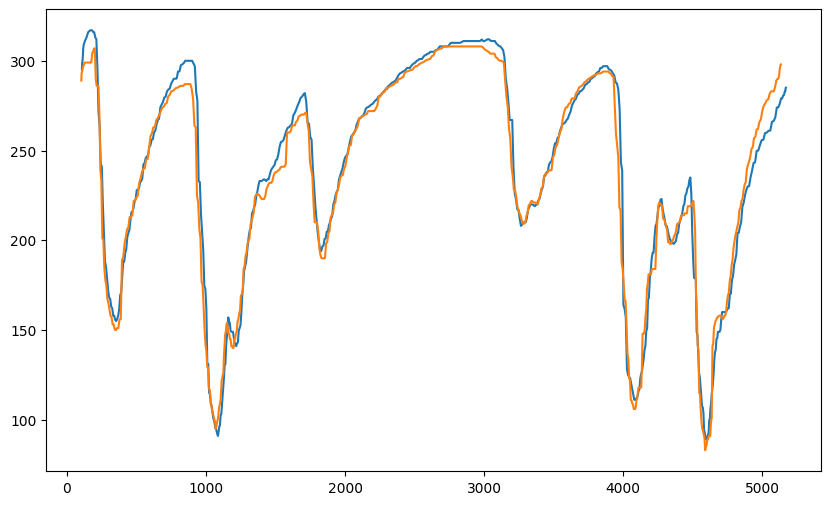

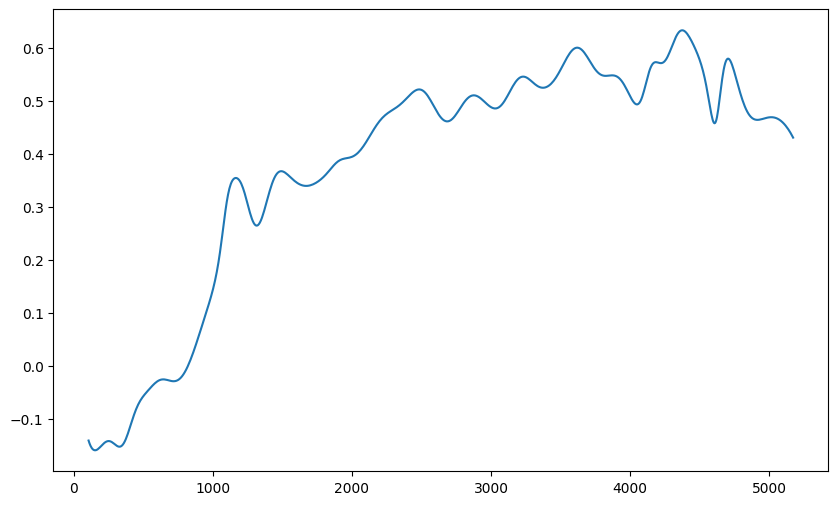

In [62]:
# plt.plot(df1.actual_distance, delta)
plt.figure(figsize=(10,6))
plt.plot(df1.actual_distance_smoothed, df1.speed)
plt.plot(df2.actual_distance_smoothed, df2.speed)
plt.show()
plt.figure(figsize=(10,6))
plt.plot(df1.actual_distance_smoothed, gaussian_filter1d(delta, sigma = 10))
plt.show()

In [ ]:
def